In [42]:
import pickle
from wild_visual_navigation import WVN_ROOT_DIR
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
ws = "_" + os.environ["ENV_WORKSTATION_NAME"]
name = "data_percentage_all"
with open(os.path.join(WVN_ROOT_DIR, f"results/ablations/{name}{ws}/{name}_steps.pkl"), "rb") as f:
    res = pickle.load(f)
    
    
# GET RUN CONFIGURATION
all_percentages = []
all_steps = []
all_runs = []
for data in res:
    data["model_path"]
    percentage, steps, run = data["percentage"], data["steps"], data["run"]
    all_runs.append(run)
    all_percentages.append(percentage)
    all_steps.append(steps)
NR_RUNS = np.unique( np.array(all_runs) ).shape[0]
NR_TRAINIG_DATA = np.unique( np.array(all_percentages) ).shape[0]
STEPS_DIV = np.unique(all_steps)[1]- np.unique(all_steps)[0]
NR_STEPS = np.unique(all_steps).shape[0]

# CHANGE STORAGE FORMAT
    
auroc_gt = {}
auroc_gt["forest"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))
auroc_gt["grassland"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))
auroc_gt["hilly"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))
auroc_prop = {}
auroc_prop["forest"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))
auroc_prop["grassland"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))
auroc_prop["hilly"] = np.zeros((NR_TRAINIG_DATA, NR_STEPS, NR_RUNS))


for data in res:
    percentage, steps, run = data["percentage"], data["steps"], data["run"]
    try:
        da = [v for v in data["results"].values()][0]
        auroc_gt[data["scene"]][int(percentage / 10) - 1, int(steps / STEPS_DIV), run] = da["test_acc_gt_image"]
        auroc_prop[data["scene"]][int(percentage / 10) - 1, int(steps / STEPS_DIV), run] = da["test_acc_self_image"]
    except:
        pass

In [37]:
auroc_gt[data["scene"]].shape

(10, 200, 1)

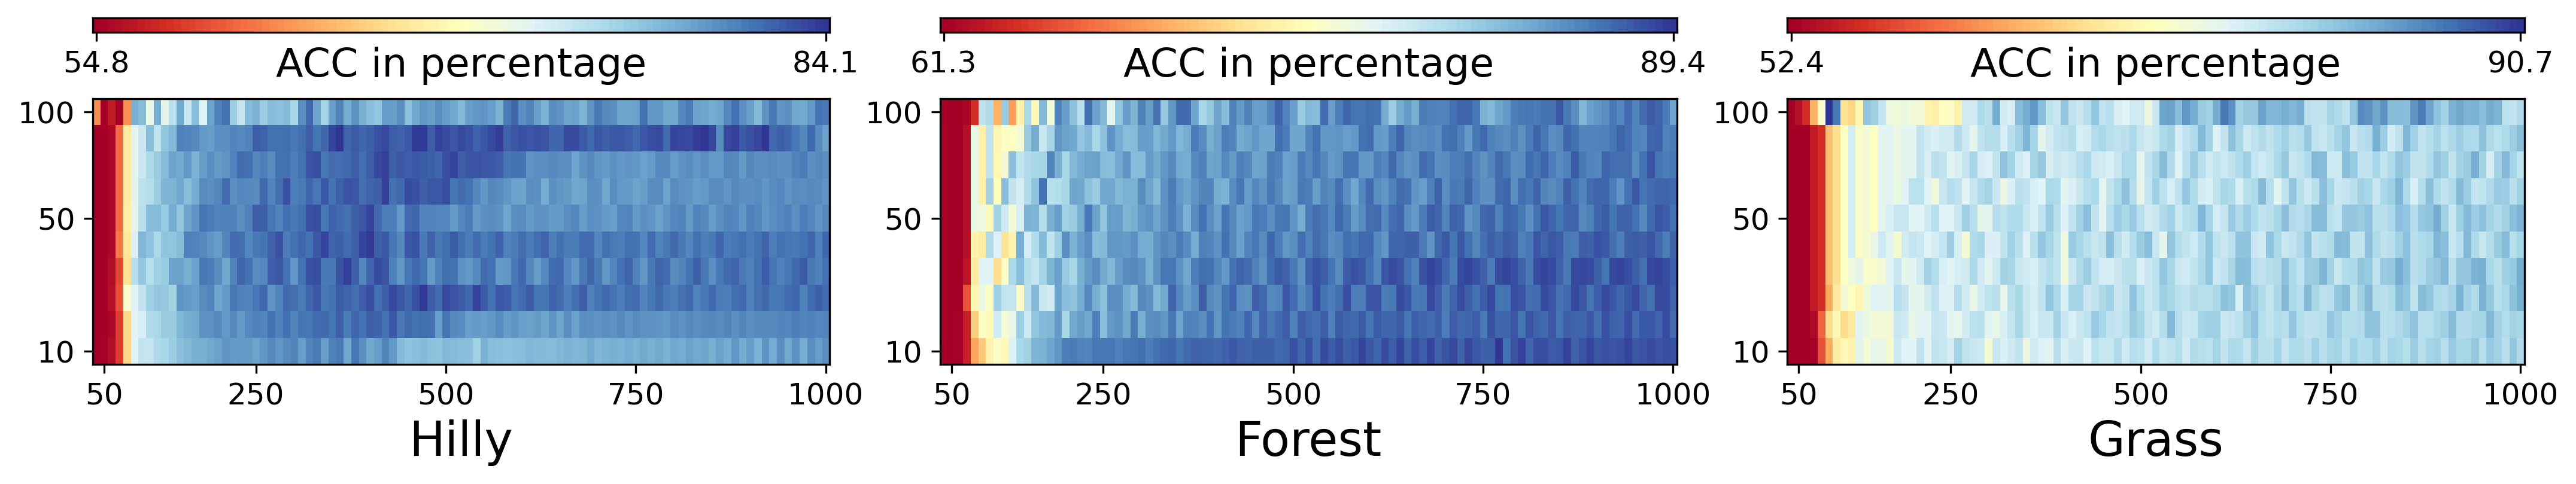

In [164]:
import matplotlib.pyplot as plt
fontdict = {
    "fontsize": 16,
    "fontweight": plt.rcParams["axes.titleweight"],
    "verticalalignment": "baseline",
    "horizontalalignment": "center",
}
def plot(title, data, env, ax0,ax1):

    

    ax1.tick_params(axis="both", which="major", labelsize=12)

    # Plot Matrix
    label_y = [str(k) for k in range(10, 101, 10)]
    label_x = [str(200)] + [str(int(j / 1000)) + "k" for j in range(300, data.shape[1] * 102, 100)]

    im = ax1.imshow(data, cmap=sns.color_palette("RdYlBu", as_cmap=True))
    

    ax1.set_xticks([1, 21, 21+ 25, 21+ 50 , 21+ 75])
    
    

    ax1.set_yticks([0,5,9])

    
    # index = np.array([0] + list(np.arange(8, 100, 10)))
    ax1.set_xticklabels([50 , 250, 500, 750, 1000])
    ax1.set_yticklabels([10,50,100])

    ax1.invert_yaxis()
    # ax[1].set_xlabel("Training Steps")
    # ax[1].set_ylabel("Data Percentage")

    plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    ax1.set_aspect(3.5)

    # Plot color bar
    nr = 100
    bar = np.arange(0, nr)[None]
    im = ax0.imshow(bar, cmap=sns.color_palette("RdYlBu", as_cmap=True))
    ax0.set_aspect(2)
    ax0.set_xticks(np.array([0, nr - 1]))
    ax0.set_yticks(np.array([]))
    ax0.set_xticklabels(np.array([round(data.min() * 100, 1), round(data.max() * 100, 1)]))
    ax0.set_yticklabels([])

    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.tick_params(axis="both", which="minor", labelsize=12)
    ax0.tick_params(axis="both", which="major", labelsize=12)
    ax0.tick_params(axis="both", which="minor", labelsize=12)

    ax0.set_xlabel("ACC in percentage", fontdict=fontdict)
    ax0.xaxis.set_label_coords(0.5, -3)
    
    ax1.set_title(title,y=-0.4)
    # plt.subplots_adjust(hspace=-0.5)
    #

scale = 2
width_half_inch, width_double_inch = 88.9 / 25.4, 182.0 / 25.4
height_inch = 33 / 25.4

fig = plt.figure(figsize=(width_double_inch * scale, height_inch * scale), dpi=300)

fig.set_tight_layout(False)

gs1 = fig.add_gridspec(nrows=2, ncols=3, left=0.035, right=0.98, top=1, wspace=0.15,height_ratios=[1,15])
ax0, ax1, ax2 = fig.add_subplot(gs1[0, 0]), fig.add_subplot(gs1[0, 1]), fig.add_subplot(gs1[0, 2])
gs2 = fig.add_gridspec(nrows=2, ncols=3, left=0.035, right=0.98, top=1.2, wspace=0.15,height_ratios=[1,5])

ax3, ax4, ax5 = fig.add_subplot(gs2[1, 0]), fig.add_subplot(gs2[1, 1]), fig.add_subplot(gs2[1, 2])
#plot("Time/Data-Adaptation ACC SELF", auroc_prop["forest"][:, 3:].mean(axis=2))

#plot("Time/Data-Adaptation ACC GT", auroc_prop["hilly"][:, 3:].mean(axis=2))
plot("Hilly", auroc_gt["hilly"][:, 3:].mean(axis=2), "hilly",ax0,ax3)
plot("Forest", auroc_gt["forest"][:, 3:].mean(axis=2), "forest",ax1,ax4)
#plot("Time/Data-Adaptation AUCROC GT", auroc_prop["grassland"][:, 3:].mean(axis=2))
da = auroc_gt["grassland"][:, 3:].mean(axis=2)
# da[da>0.85] = da[da<0.85].max()
plot("Grass", da , "grassland",ax2,ax5)
fig.savefig(f"/tmp/img.png")
fig.savefig(f"/tmp/img.pdf")

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, Fals

In [56]:
auroc_gt["grassland"][:, 3:].mean(axis=2).shape


(10, 97)